In [ ]:
# Install the required libraries
import pandas as pd
import kagglehub
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import pipeline
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
path = kagglehub.dataset_download("myrios/news-sentiment-analysis")
df= pd.read_csv(path+"/news.csv")

100%|██████████| 28.8M/28.8M [00:00<00:00, 119MB/s] 

Extracting files...


In [ ]:
# Take "news" and "sentiment" columns
df =df[['news','sentiment']]
df.head()

,news,sentiment
0,It was a long antipodean night. While there’s ...,POSITIVE
1,In Mexico there are no licensing or registrati...,NEGATIVE
2,The government has until Monday to protect the...,POSITIVE
3,A record-breaking heat wave in the Southwest i...,POSITIVE
4,England started its Live Earth concert at Wemb...,NEGATIVE


In [ ]:
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

Number of rows: 427482
Number of columns: 2


In [ ]:
print(f"Number of missing values: {df.isnull().sum().sum()}")
print(f"Number of duplicated rows: {df.duplicated().sum()}")

Number of missing values: 0
Number of duplicated rows: 12762


In [ ]:
df.drop_duplicates(inplace=True)

<Axes: xlabel='sentiment', ylabel='count'>

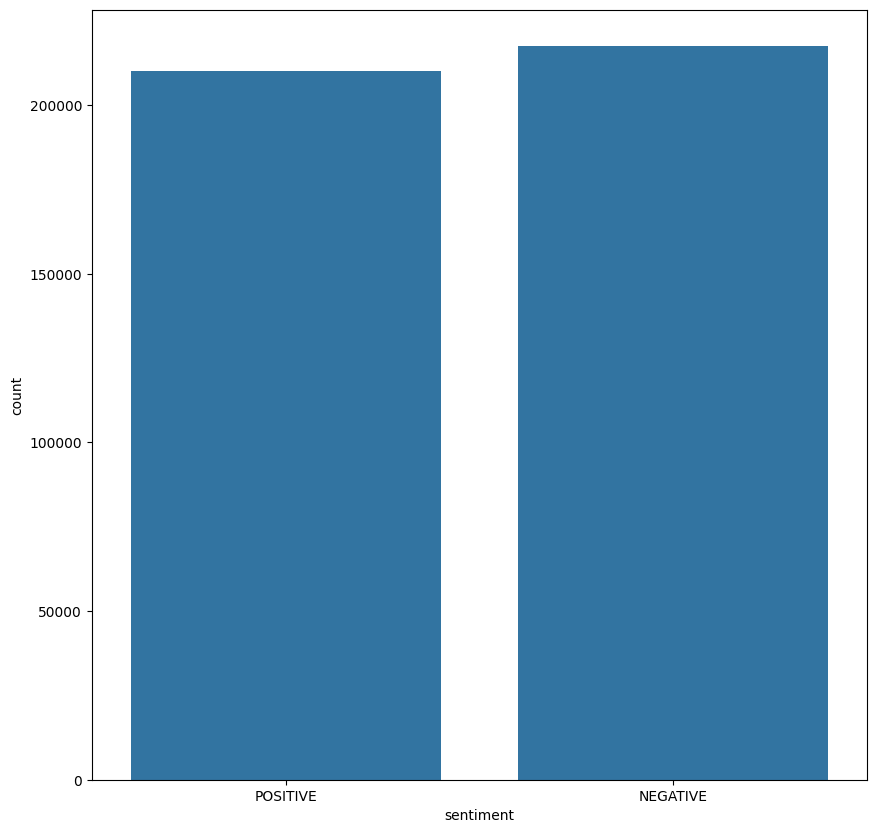

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(x='sentiment',data=df)

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
df['sentiment'] = df['sentiment'].map({'NEGATIVE':0,'POSITIVE':1})

In [ ]:
X= list(df['news'])
y= list(df['sentiment'])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4,stratify=y)

In [ ]:
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

In [ ]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [ ]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [ ]:
def compute_metrics(p):
    print(type(p))
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
# Define Trainer
args = TrainingArguments(
    output_dir="output",
    num_train_epochs=1,
    per_device_train_batch_size=32

)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer = tokenizer
)

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ayaalalawni2006 (ayaalalawni2006-arab-american-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.415100
1000,0.303600
1500,0.267500
2000,0.248000
2500,0.235700
3000,0.209100
3500,0.201000
4000,0.193100
4500,0.188500
5000,0.177200


Step,Training Loss
500,0.415100
1000,0.303600
1500,0.267500
2000,0.248000
2500,0.235700
3000,0.209100
3500,0.201000
4000,0.193100
4500,0.188500
5000,0.177200


TrainOutput(global_step=8016, training_loss=0.21159453205243794, metrics={'train_runtime': 6918.5681, 'train_samples_per_second': 37.073, 'train_steps_per_second': 1.159, 'total_flos': 2.0770747621375116e+16, 'train_loss': 0.21159453205243794, 'epoch': 1.0})

In [ ]:
trainer.evaluate()

<class 'transformers.trainer_utils.EvalPrediction'>


{'eval_loss': 0.13700032234191895,
 'eval_accuracy': 0.9436994496850748,
 'eval_precision': 0.9421442411706668,
 'eval_recall': 0.943344124928585,
 'eval_f1': 0.942743801259672,
 'eval_runtime': 1516.1481,
 'eval_samples_per_second': 112.781,
 'eval_steps_per_second': 14.098,
 'epoch': 1.0}

In [ ]:
trainer.save_model('CustomModel')

In [ ]:
! huggingface-cli login

In [ ]:
trainer.push_to_hub("CustomModel")